## Ricker Model estimation with approximated likelihood ratios

Juan Pavez, March 2016.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
matplotlib.style.use('ggplot')

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/carl')

np.random.seed(1234)

In [2]:
def logit(x):
    return np.log(x) - np.log(1-p)
def logistic(x):
    return 1. / (1. + np.exp(-x)) 


In [3]:
r_value = 4.0
sigma_2_value = 0.3**2
phi_value = 5.
r_bkg = 5.
phi_bkg = 8.

shared_r = theano.shared(r_value, name="r")
shared_sigma_2 = theano.shared(sigma_2_value,name="sigma_2")
shared_phi = theano.shared(phi_value, name="phi")

class Ricker:
    def __init__(self,r,sigma_2,phi):
        self.r = r
        self.sigma_2 = sigma_2
        self.phi = phi
    
    def sample(self,r=0.5, sigma_2=1., phi=0.1, start=0.1,n_timesteps=1000, rng=None):
        noise = rng.normal(0.,sigma_2, n_timesteps)
        time_serie = np.zeros(n_timesteps,dtype=np.float64)
        time_serie[0] = np.abs(noise[0])
        r_e = np.exp(r)
        for i in range(1,n_timesteps):
            time_serie[i] = (r_e*time_serie[i-1]*np.exp(-time_serie[i-1] + noise[i]))

        sampled = np.zeros(n_timesteps)
        sampled = np.array([rng.poisson(phi*time_serie[i]) for i in range(0,n_timesteps,1)])
        
        return_serie = np.log(time_serie[1:]/(time_serie[:-1]))
        
        return time_serie.reshape(time_serie.shape[0],1), sampled.reshape(sampled.shape[0],1),return_serie.reshape(return_serie.shape[0],1)
    def rvs(self,n_samples, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        return self.sample(r=self.r.eval(),sigma_2=self.sigma_2.eval(),phi=self.phi.eval(),
                     n_timesteps=n_samples,rng=rng)[1]
                
    
#serie1,sampled1 = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
#serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)

#X_true,X_true_obs = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=1500,start=0.5)


In [4]:
n_samples = 5000000 # train
test_samples = 1500 # test
hist_samples = 50000 # histograms
n_bins = 15 # histogram construction
# best results 10000,1500,10000,15,4,100

In [5]:
p0 = Ricker(r=shared_r,sigma_2=shared_sigma_2,phi=shared_phi)
#p1 = Ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.)
p1 = Ricker(r = theano.shared(r_bkg, name="r_1"),
            sigma_2 = theano.shared(0.3**2,name="sigma_2_1"),
            phi = theano.shared(phi_bkg, name="phi_1")
            )
rng = np.random.RandomState(1234)

X_true = p0.rvs(test_samples, random_state=rng)


0 110
0 516


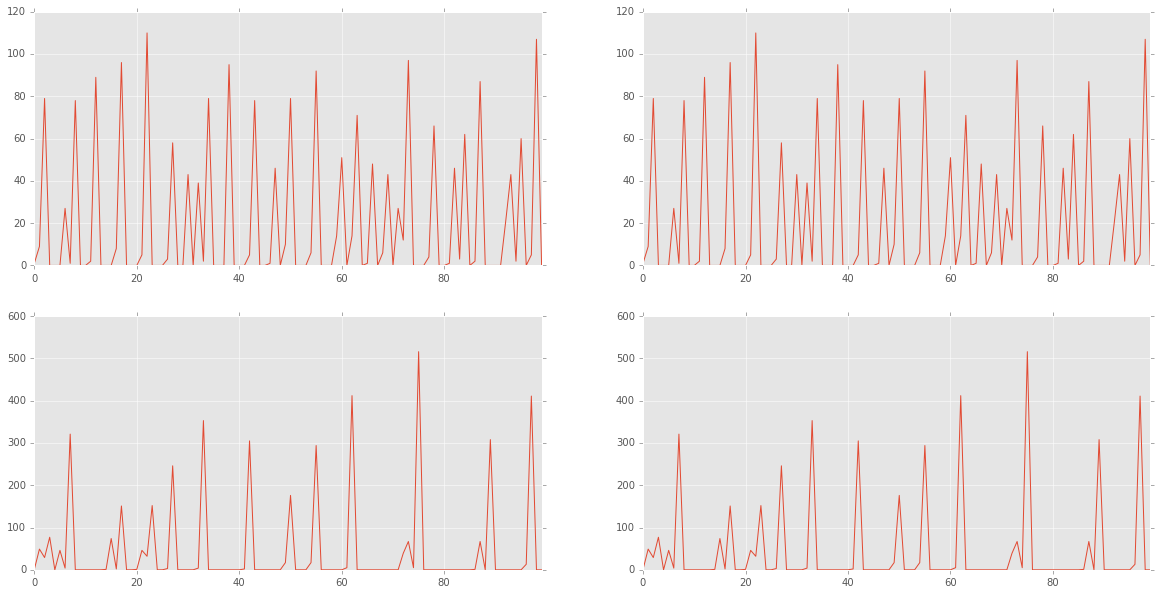

In [6]:
serie1 = p0.rvs(100).ravel()
serie2 = p1.rvs(100).ravel()
plt.figure(figsize=(20,10))
plt.subplot(221)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(222)
ts = pd.Series(serie1)
ts.plot()
plt.subplot(223)
ts = pd.Series(serie2)
ts[0:100].plot()
plt.subplot(224)
ts = pd.Series(serie2)
ts.plot()
print serie1.min(),serie1.max()
print serie2.min(),serie2.max()

In [7]:
from carl.learning import ParameterStacker

from itertools import product
def make_parametrized_classification_std(p0, p1, n_samples, params, rng):
    if not isinstance(params[0], tuple):
        X0 = p0.rvs(n_samples // 2, random_state=rng)
        X1 = p1.rvs(n_samples - (n_samples // 2), random_state=rng)
        X = ParameterStacker(params).transform(np.vstack((X0, X1)))
        y = np.zeros(n_samples)
        y[len(X0):] = 1

        return X, y

    elif isinstance(params[0], tuple):
        combinations = list(product(*[values for _, values in params]))

        all_X = []
        all_y = []

        for c in combinations:
            for i, v in enumerate(c):
                params[i][0].set_value(v)

            X, y = make_parametrized_classification_std(
                p0, p1,
                n_samples // len(combinations),
                [p for p, _ in params], rng=rng)

            all_X.append(X)
            all_y.append(y)

        X = np.vstack(all_X)
        y = np.concatenate(all_y)

        return X, y

    else:
        raise ValueError

In [8]:
X, y = make_parametrized_classification_std(
    p0, p1,
    n_samples, 
    [(shared_r, np.linspace(3.3,4.5, num=20)),
    (shared_phi, np.linspace(3.5,7.5,num=20))],
    rng=1234)

In [9]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Dropout
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, Adam


def make_model():
    model = Sequential()
    model.add(Dense(5,input_shape=(X.shape[1],)))
    #model.add(Dropout(0.3))
    #model.add(Dense(5,activation='tanh'))
    #model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    #sgd = SGD(lr=0.01, clipnorm=40.)
    adam = Adam(clipnorm=40.)
    model.compile(loss="binary_crossentropy", optimizer=adam)
    return model


clf = KerasClassifier(make_model, nb_epoch=30, verbose=2)
#clf = make_pipeline(StandardScaler(),as_classifier(clf))

clf.fit(X=X, y=y)
#clf.fit(X=X_serie, y=y_serie,nb_epoch=3,batch_size=32,verbose=2)

Epoch 1/30
54s - loss: 0.6915
Epoch 2/30
55s - loss: 0.6862
Epoch 3/30
53s - loss: 0.6858
Epoch 4/30
53s - loss: 0.6858
Epoch 5/30
54s - loss: 0.6858
Epoch 6/30
54s - loss: 0.6858
Epoch 7/30
52s - loss: 0.6858
Epoch 8/30
54s - loss: 0.6858
Epoch 9/30
54s - loss: 0.6858
Epoch 10/30
54s - loss: 0.6858
Epoch 11/30
54s - loss: 0.6858
Epoch 12/30
52s - loss: 0.6858
Epoch 13/30
54s - loss: 0.6858
Epoch 14/30
48s - loss: 0.6858
Epoch 15/30
47s - loss: 0.6858
Epoch 16/30
48s - loss: 0.6858
Epoch 17/30
47s - loss: 0.6858
Epoch 18/30
46s - loss: 0.6858
Epoch 19/30
46s - loss: 0.6858
Epoch 20/30
47s - loss: 0.6858
Epoch 21/30
47s - loss: 0.6858
Epoch 22/30
47s - loss: 0.6858
Epoch 23/30
47s - loss: 0.6858
Epoch 24/30
47s - loss: 0.6858
Epoch 25/30
47s - loss: 0.6858
Epoch 26/30
46s - loss: 0.6858
Epoch 27/30
47s - loss: 0.6858
Epoch 28/30
47s - loss: 0.6858
Epoch 29/30
47s - loss: 0.6858
Epoch 30/30
48s - loss: 0.6858


Using Theano backend.


In [10]:
print clf.predict_proba(X)

[[ 0.51555514  0.48444489]
 [ 0.51313746  0.48686254]
 [ 0.49217075  0.50782925]
 ..., 
 [ 0.35731202  0.64268798]
 [ 0.52340317  0.47659686]
 [ 0.52340317  0.47659686]]


In [11]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, bins=30, cv='prefit', 
                                         method='histogram'), 
    random_state=0)
cc_direct.fit(X=X,y=y)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x793cc90>,
            bins=30, cv='prefit', method='histogram'),
        random_state=0)

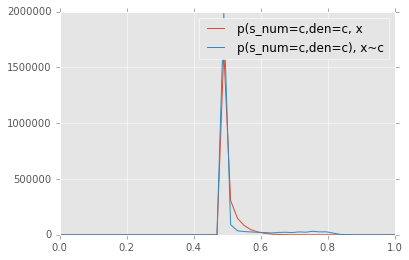

In [12]:
reals2 = np.linspace(0, 1)

cal_num, cal_den = cc_direct.classifier_.calibrators_[0].calibrators
plt.plot(reals2, cal_num.pdf(reals2.reshape(-1, 1)), 
         label="p(s_num=c,den=c, x")
plt.plot(reals2, cal_den.pdf(reals2.reshape(-1, 1)), 
        label="p(s_num=c,den=c), x~c")
plt.legend()
plt.show()


In [13]:

from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio
import pdb

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

def objective(theta, random_state=0, X_true=None):    
    #print(theta)
    shared_r.set_value(theta[0])
    shared_phi.set_value(theta[1])
    serie1 = p0.rvs(hist_samples)
    #serie1 = (serie1 - serie1.mean()) / serie1.std()
    # Set parameter values   
    X0 = np.zeros((serie1.shape[0],serie1.shape[1]+2))
    X0[:,:-2] = serie1
    X0[:,-2] = theta[0]
    X0[:,-1] = theta[1]
    
    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=40))

    serie2 = p1.rvs(hist_samples,random_state=random_state)
    #serie2 = (serie2 - m1) / s1
    X1 = np.zeros((serie2.shape[0],serie2.shape[1]+2))
    X1[:,:-2] = serie2
    #X1[:,-2] = r_bkg
    #X1[:,-1] = phi_bkg
    X1[:,-2] = theta[0]
    X1[:,-1] = theta[1]

    #X0_serie = X0_serie[np.random.choice(X0_serie.shape[0],X0_serie.shape[0],replace=False)]
    #X1_serie = X1_serie[np.random.choice(X1_serie.shape[0],X1_serie.shape[0],replace=False)]

    X = np.vstack((
         X0,
         X1))
    y = np.zeros(X0.shape[0]*2,dtype=np.int)
    y[X0.shape[0]:] = 1
    
    ratio.fit(X, y)
    
    # Evaluate log-likelihood ratio
    X_true_ = np.zeros((X_true.shape[0],X_true.shape[1]+2))
    X_true_[:,:-2] = X_true
    X_true_[:,-2] = theta[0]
    X_true_[:,-1] = theta[1]
    
    #X_true_serie = X_true_serie[np.random.choice(X_true_serie.shape[0],X_true_serie.shape[0],
    #                                            replace=False)]
    
    r = ratio.predict(X_true_, log=True)
    zeros = r[np.isinf(r)].shape
    #print r[np.isfinite(r)].shape
    #value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                         # this will need to be rescaled by len(X_true)
    
    #r[np.isinf(r)] = 0.
    value = -np.mean(r[np.isfinite(r)])
    #print zeros
    #print value

    return value, zeros[0]


In [14]:

# Contours of the approximated LR
shared_r.set_value(r_value)
shared_phi.set_value(phi_value)

bounds = [(3.7,4.3),
          (3.5,7.)]

As = np.linspace(bounds[0][0],bounds[0][1], 10)
Bs = np.linspace(bounds[1][0],bounds[1][1], 10)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

In [15]:
approx_contours = np.zeros(len(X))
zeros = np.zeros(len(X))
X_true = p0.rvs(20000, random_state=np.random.randint(0,5000))

i = 0
for a in As:    
    for b in Bs:
        approx_contours[i],zeros[i] = objective([a, b],X_true=X_true) 
        i += 1
        
approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)

In [16]:
approx_contours

array([ 10215.92433144,  18030.29552347,  10665.70663311,   9644.25773254,
         5957.97408562,   3567.267535  ,   2353.54559602,   1465.33352531,
         1154.02153487,   1320.85400707,  17677.53708026,  10955.69762021,
        10606.55796659,   6075.06476141,   2996.79724603,   1880.80982252,
          880.32488425,    636.93265271,    840.22361518,   1214.1412498 ,
        15104.99255474,  10981.06897448,   6581.93988769,   3312.35341212,
         1718.89620698,    635.55393552,    337.15926769,    465.25185558,
          945.09329036,   1536.0597692 ,   9759.27779065,   8555.81364102,
         3724.5752445 ,   1714.78170067,    594.66586852,    109.46128954,
          206.05891779,    686.43374028,   1336.17350342,   2066.27367827,
         9805.83006461,   5011.58144425,   1711.43068686,    593.20631589,
            0.        ,     98.26314561,    564.61417531,   1232.15640637,
         2010.0556299 ,   2675.78029308,   6919.62649872,   2789.86204421,
          979.92438952,  

(3.9666666666666668, 5.0555555555555554) 

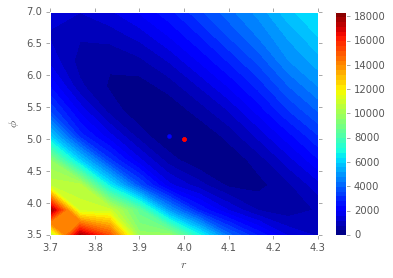

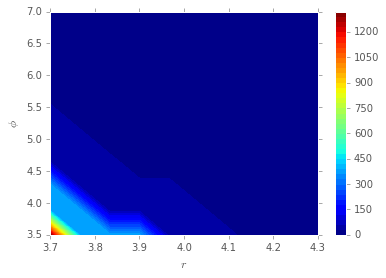

In [17]:
from scipy.stats import chi2
import pdb

min_value = np.unravel_index(approx_contours.argmin(),
            (10,10))
min_position = (As[min_value[0]],Bs[min_value[1]])
print '{0} '.format(min_position),
#plt.contour(As, Bs, approx_contours.reshape(AA.shape).T, 
#            levels=[chi2.ppf(0.683, df=2), 
#                    chi2.ppf(0.9545, df=2),
#                    chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, approx_contours.reshape(AA.shape).T, 50)
plt.colorbar()

plt.plot([r_value], [phi_value], "r.", markersize=8)
plt.plot([r_value], [phi_value], "r.", markersize=8)
plt.plot([min_position[0]], [min_position[1]], "b.", markersize=8)


plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.xlabel(r"$ r$")
plt.ylabel(r"$\phi$")

#plt.savefig("fig4c.pdf")
plt.show()

plt.contourf(As, Bs, zeros.reshape(AA.shape).T, 50)
plt.colorbar()

plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.xlabel(r"$ r$")
plt.ylabel(r"$\phi$")
plt.show()

In [18]:
n_hist = 30
hist_values = np.zeros((n_hist,2))
approx_contours = np.zeros(len(X))


for h in range(n_hist):
    shared_r.set_value(r_value)
    shared_phi.set_value(phi_value)
    random_state = np.random.randint(0,5000)
    print(random_state)
    X_true = p0.rvs(500,random_state=random_state)
    zeroes = np.zeros(len(X))
    i = 0
    for a in As:    
        for b in Bs:
            approx_contours[i],zeros[i] = objective([a, b],X_true=X_true) 
            i += 1
        
    approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)
    min_value = np.unravel_index(approx_contours.argmin(),
                (10,10))
    min_position = (As[min_value[0]],Bs[min_value[1]])
    print '{0} '.format(min_position),
    hist_values[h] = min_value
#approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)


4817
(4.0333333333333332, 5.0555555555555554)  1400
(4.0999999999999996, 4.666666666666667)  3937
(3.9666666666666668, 5.0555555555555554)  3323
(4.0333333333333332, 4.666666666666667)  1010
(3.9666666666666668, 5.0555555555555554)  611
(4.0333333333333332, 5.0555555555555554)  262
(3.9666666666666668, 5.0555555555555554)  834
(3.9666666666666668, 5.0555555555555554)  4790
(3.9666666666666668, 5.4444444444444446)  606
(3.9666666666666668, 5.0555555555555554)  4622
(3.8999999999999999, 5.4444444444444446)  4497
(4.0333333333333332, 4.666666666666667)  4863
(3.9666666666666668, 5.0555555555555554)  2679
(4.0333333333333332, 5.0555555555555554)  4205
(3.8999999999999999, 5.4444444444444446)  3668
(3.8999999999999999, 5.4444444444444446)  4682
(4.0333333333333332, 5.0555555555555554)  1946
(4.0333333333333332, 4.666666666666667)  2640
(4.0333333333333332, 5.0555555555555554)  3665
(4.0333333333333332, 5.0555555555555554)  678
(3.9666666666666668, 5.0555555555555554)  4447
(3.96666666666666

In [20]:
min_positions = np.array([[As[min_val[0]],Bs[min_val[1]]] for min_val in hist_values])
print('Min position: {0} +- {1}'.format(min_positions[:,0].mean(), min_positions[:,0].std()))
print('Min position: {0} +- {1}'.format(min_positions[:,1].mean(), min_positions[:,1].std()))

Min position: 3.98 +- 0.0581186525805
Min position: 5.09444444444 +- 0.253026942725


/afs/cern.ch/user/j/jpavezse/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#print gp_ratios
print(min_positions[:,1])
ax.hist(min_positions[:,1], range=(3.,7.), 
        label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=5.)$", bins=10)
ax.set_xlabel(r"$approx \phi$")
ax.set_ylabel(r"$Count$")
#plt.legend()

ax.legend()
ax.set_ylim(0., 25.)
#ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=phi_value,linestyle='dashed',alpha=0.5)
plt.savefig('likelihood_comp.pdf')
plt.show()

TO-DO:
* 2D parameter estimation.
* Parameter estimation on $Y_t$ (here the method must be adapted for state space models).

* Check with other parameters
* Try with an easier model e.g simple autoregresive model

In [ ]:
As[min_value[0]],Bs[min_value[1]]
